### Test and validate lcdb chipseq-wf with S2 cell modENCODE data

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline

In [2]:
sra = pd.read_csv('../../output/chip/20171103_s2cell_chip-seq.csv')
sra.head()

In [3]:
modENCODE = pd.read_table('../../data/modENCODE_sampletable.tsv')
modENCODE.head()

In [5]:
len(modENCODE.srx.unique())

1707

In [8]:
merged = sra.merge(modENCODE, on='srx', how='inner')

In [9]:
merged.shape

(51, 13)

In [10]:
merged.modENCODE_id.unique()

array(['modENCODE_2638', 'modENCODE_2639', 'modENCODE_4715',
       'modENCODE_4716', 'modENCODE_2979', 'modENCODE_3953',
       'modENCODE_5595', 'modENCODE_5596'], dtype=object)

In [11]:
mymod = pd.read_table('../../output/chip/modENCODE_big.bed', header=None, names=['chrom', 'start','stop','score','strand','modENCODE_id','type','stage','otherid'])

In [13]:
check = mymod.merge(merged, on='modENCODE_id', how='inner')

In [14]:
check.srr_x.unique()

array(['SRR034720 | SRR034721', 'SRR034722', 'SRR034724 | SRR034723',
       'SRR034725'], dtype=object)

In [15]:
check.geo.unique()

array(['GSM499649', 'GSM499650', 'GSM499651', 'GSM499652'], dtype=object)

did a fastq dump for the above SRRs and ran them through the chipseq-wf. now validation: 

In [16]:
other_data = check[['chrom','start','stop','srx']]
other_data.to_csv('../../output/chip/modE_s2.bed', header=None, index=False, sep='\t')

In [17]:
SRX016158_narrow = pd.read_table('../../chipseq-wf/data/chipseq_peaks/macs2/CTCF-1-narrow/peaks.bed', header=None)

import result of bedtools coverage test: 

In [20]:
coverage = pd.read_table('../../output/chip/peakintersecttest', header=None)[[0,1,2,3,12]]
coverage.columns = ['chrom','start','end','name','overlap']

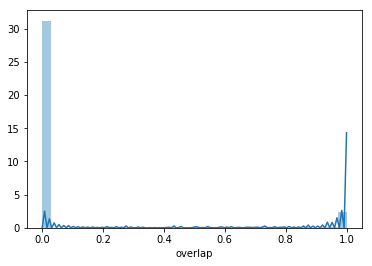

In [23]:
sb.distplot(coverage['overlap'])

In [52]:
filtered = coverage[coverage.overlap > 0.01]

In [53]:
filtered['chrom'] = ['chr'+str(x) for x in filtered.chrom]

/data/bergeric/miniconda3/envs/s2rnai/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
filtered[['chrom','start','end','name']].to_csv('../../output/chip/filteredpeaks', header=None, index=False, sep='\t')

## Another round of testing: 

Justin thought that one of the reasons our coverage looks so bad above could be that CTCF is "weird", so trying again with h3k9me3.  

In [33]:
h3k9 = pd.read_csv('../../output/chip/results-table.csv')

In [39]:
h3k9bed = h3k9[['Binding Site > Chromosome > DB identifier',
       'Binding Site > Chromosome Location > Start',
       'Binding Site > Chromosome Location > End',]]

In [41]:
h3k9bed.to_csv('../../output/chip/h3k9.bed', header=None, index=False, sep='\t')

In [42]:
fixbed = pd.read_table('../../output/chip/h3k9.bed', header=None)

In [44]:
fixbed[0] = ['chr'+str(x) for x in fixbed[0]]

In [47]:
fixbed.to_csv('../../output/chip/liftmeover.bed', header=None, index=False, sep='\t')

Import bedtools coverage test results again: 

In [48]:
coverage2 = pd.read_table('../../output/chip/peakcoverage_test2', header=None)

In [51]:
coverage2.shape

(511, 13)

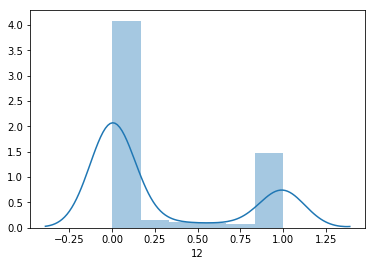

In [50]:
sb.distplot(coverage2[12])

Coverage comparison with modENCODE: 

In [2]:
test_coverage = pd.read_table('../../output/chip/test_coverage.bed', header=None)[[3,4]]

test_coverage['gene_id'] = [x.split(';')[0].split()[1].strip('"')for x in test_coverage[3]]
test_coverage['gene_symbol'] = [x.split(';')[1].split()[1].strip('"')for x in test_coverage[3]]
test_coverage['count'] = test_coverage[4]
test_coverage = test_coverage[['gene_id','gene_symbol','count']]

In [3]:
mod_coverage = pd.read_table('../../output/chip/modENCODE_coverage.bed', header=None)

mod_coverage['gene_id'] = [x.split(';')[0].split()[1].strip('"')for x in mod_coverage[3]]
mod_coverage['gene_symbol'] = [x.split(';')[1].split()[1].strip('"')for x in mod_coverage[3]]
mod_coverage['count'] = mod_coverage[4]
mod_coverage = mod_coverage[['gene_id','gene_symbol','count']]

In [4]:
mod_coverage.head()

,gene_id,gene_symbol,count
0,FBgn0031081,Nep3,3
1,FBgn0052826,tRNA:Pro-CGG-1-1,3
2,FBgn0031085,CG9570,3
3,FBgn0062565,Or19b,1
4,FBgn0031088,CG15322,3


In [5]:
test_coverage.head()

,gene_id,gene_symbol,count
0,FBgn0031081,Nep3,3
1,FBgn0052826,tRNA:Pro-CGG-1-1,0
2,FBgn0031085,CG9570,0
3,FBgn0062565,Or19b,0
4,FBgn0031088,CG15322,0


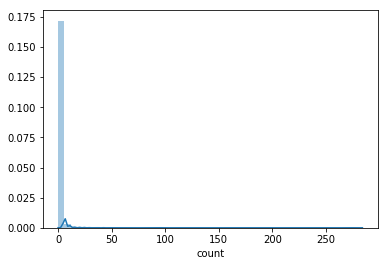

In [6]:
sb.distplot(mod_coverage['count'])

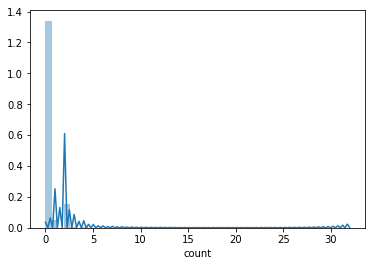

In [7]:
sb.distplot(test_coverage['count'])

In [8]:
merged = test_coverage.merge(mod_coverage, how='outer', on=['gene_id', 'gene_symbol'])

In [9]:
merged['difference'] = abs(merged.count_x - merged.count_y)

In [10]:
merged.head()

,gene_id,gene_symbol,count_x,count_y,difference
0,FBgn0031081,Nep3,3,3,0
1,FBgn0052826,tRNA:Pro-CGG-1-1,0,3,3
2,FBgn0031085,CG9570,0,3,3
3,FBgn0062565,Or19b,0,1,1
4,FBgn0031088,CG15322,0,3,3


In [11]:
merged.difference.describe()

count    17728.000000
mean         0.797270
std          3.166568
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        252.000000
Name: difference, dtype: float64

In [13]:
merged['count_x'].corr(merged['count_y'], method='spearman')

0.56216334667596035

In [22]:
merged.shape

(17728, 5)

In [18]:
import matplotlib.pyplot as plt

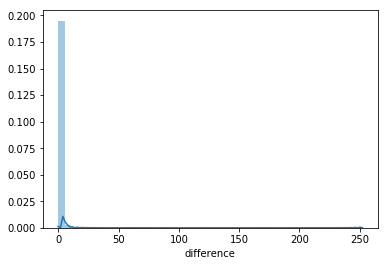

In [40]:
sb.distplot(merged.difference)

In [45]:
from math import sqrt
 
def euclidean_distance(x,y):
 
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

In [46]:
euclidean_distance(merged.count_x, merged.count_y)

434.76430396250333

In [49]:
results = []
for bs in range(10000):
    sub1 = merged.count_x.sample(n=17728, replace=True)
    sub2 = merged.count_y.sample(n=17728, replace=True)
    metric = euclidean_distance(sub1, sub2)
    results.append(metric)

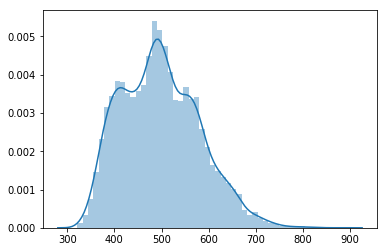

In [50]:
sb.distplot(results)